In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import mediapipe as mp
import seaborn as sns
import matplotlib.pyplot as plt
import threading

from tensorflow import keras
from tensorflow.keras import layers, backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
)
from tensorflow.keras.utils import get_custom_objects, to_categorical
from tensorflow.keras.applications import ResNet50  # Using ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from keras_vggface.vggface import VGGFace  # Import VGGFace2 Model
from keras_vggface.utils import preprocess_input

# Suppress TensorFlow logs (only show errors)
tf.get_logger().setLevel('ERROR')


In [2]:
# Load the dataset
train_df = pd.read_csv('raf-db/train_labels.csv')
val_df = pd.read_csv('raf-db/test_labels.csv')
train_df = train_df.rename(columns={'image': 'pth', 'label': 'label'})
val_df = val_df.rename(columns={'image': 'pth', 'label': 'label'})

BASE_PATH = "DATASET/train/"
# Function to update paths
def update_path(row):
    return os.path.join(BASE_PATH, str(row['label']), row['pth'])

# Apply function to update the 'path' column
train_df['pth'] = train_df.apply(update_path, axis=1)

BASE_PATH = "DATASET/test/"
val_df['pth'] = val_df.apply(update_path, axis=1)

print("Training Dataset : " + str(train_df['label'].value_counts()))
print("Validation Dataset : " + str(val_df['label'].value_counts()))

# Initialize face detection model
mp_face_detection = mp.solutions.face_detection
face_detector = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Set the target image size (IMG_SIZE)
IMG_SIZE = 224

Training Dataset : label
4    4772
7    2524
5    1982
1    1290
3     717
6     705
2     281
Name: count, dtype: int64
Validation Dataset : label
4    1185
7     680
5     478
1     329
6     162
3     160
2      74
Name: count, dtype: int64


I0000 00:00:1741500684.047994 1494245 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1741500684.227871 1494346 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.06), renderer: NVIDIA TITAN Xp/PCIe/SSE2


In [3]:
val_df.head()

,pth,label
0,DATASET/test/5/test_0001_aligned.jpg,5
1,DATASET/test/1/test_0002_aligned.jpg,1
2,DATASET/test/4/test_0003_aligned.jpg,4
3,DATASET/test/1/test_0004_aligned.jpg,1
4,DATASET/test/5/test_0005_aligned.jpg,5


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [4]:
lock = threading.Lock()
def detect_and_crop_face(image):
    """Detects and crops the face using BlazeFace (MediaPipe), then resizes to target size."""
    with lock:
        if image is None:
            print("Empty")
            
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Process the image with face detection
        results = face_detector.process(img_rgb)
    
        if results.detections:
            for detection in results.detections:
                bboxC = detection.location_data.relative_bounding_box
                h, w, _ = image.shape
    
                # Calculate bounding box coordinates
                x_min = int(bboxC.xmin * w)
                y_min = int(bboxC.ymin * h)
                box_width = int(bboxC.width * w)
                box_height = int(bboxC.height * h)
    
                # Optionally expand the bounding box slightly
                x_min = max(0, x_min - box_width // 10)
                y_min = max(0, y_min - box_height // 10)
                box_width = min(w, box_width + box_width // 5)
                box_height = min(h, box_height + box_height // 5)
    
                # Crop the face from the image using the bounding box
                cropped_face = image[y_min:y_min + box_height, x_min:x_min + box_width]
                
                # Resize the cropped face to the target size (IMG_SIZE x IMG_SIZE)
                return cv2.resize(cropped_face, (IMG_SIZE, IMG_SIZE))
    
        # If no face detected, return resized version of the original image
        return cv2.resize(image, (IMG_SIZE, IMG_SIZE))

W0000 00:00:1741500684.283699 1494341 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [5]:
# Define emotion labels
emotion_labels = ['1', '2', '3', '4', '5', '6', '7']
num_classes = len(emotion_labels)  # 7 classes

def image_generator(dataframe, batch_size=32):
    while True:
        batch_images = []
        batch_labels = []
        
        dataframe = dataframe.sample(frac=1).reset_index(drop=True)  # Shuffle at start of epoch

        for i in range(len(dataframe)):
            row = dataframe.iloc[i]
            img_path = os.path.join('raf-db', row['pth'])  # Ensure path correctness
            image = cv2.imread(img_path)

            # Detect and crop the face
            face = detect_and_crop_face(image)
            if face is not None:
                batch_images.append(face)

                # Convert label from string to index
                label_str = str(row['label'])
                if label_str not in emotion_labels:
                    print(f"Warning: Unexpected label '{label_str}' found!")
                    continue  # Skip if label is not in predefined list

                label_index = emotion_labels.index(label_str)

                one_hot_label = to_categorical(label_index, num_classes=num_classes)

                batch_labels.append(one_hot_label)

            # Yield batch when full
            if len(batch_images) == batch_size:
                yield np.array(batch_images).astype('float32') / 255.0, np.array(batch_labels)
                batch_images = []
                batch_labels = []

        # Yield remaining images if any
        if len(batch_images) > 0:
            yield np.array(batch_images).astype('float32') / 255.0, np.array(batch_labels)


In [6]:
x_batch, y_batch = next(image_generator(train_df, batch_size=32))
print("Batch X shape:", x_batch.shape)  
print("Batch Y shape:", y_batch.shape)  

Batch X shape: (32, 224, 224, 3)
Batch Y shape: (32, 7)


In [7]:
# CNN Feature Extractor 1
def create_cnn_feature_extractor_1():
    inputs = keras.Input(shape=(224, 224, 3))
    x = layers.Conv2D(8, (75, 75), activation="relu", padding="same")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, (50, 50), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (25, 25), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (15, 15), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (9, 9), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    return keras.Model(inputs, x, name="CNNFeatureExtractor_1")

# Mixture of Experts (MoE)
def create_moe(input_dim, num_experts=4, top_k=2, name="MoE"):
    inputs = keras.Input(shape=(input_dim,))
    experts = [layers.Dense(input_dim, activation="relu") for _ in range(num_experts)]
    
    gating_logits = layers.Dense(num_experts)(inputs)
    gating = layers.Softmax()(gating_logits)
    
    expert_outputs = tf.stack([experts[i](inputs) for i in range(num_experts)], axis=1)
    top_k_values, top_k_indices = tf.math.top_k(gating, k=top_k)

    output = tf.zeros_like(inputs)
    for i in range(top_k):
        expert_idx = top_k_indices[:, i]
        expert_out = tf.gather(expert_outputs, expert_idx, axis=1, batch_dims=1)
        output += tf.expand_dims(top_k_values[:, i], -1) * expert_out
    
    return keras.Model(inputs, output, name=name)

# CNN Feature Extractor 2
def create_cnn_feature_extractor_2():
    inputs = keras.Input(shape=(224, 224, 3))
    x = layers.Conv2D(16, (15, 15), activation="relu", padding="same")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (7, 7), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (5, 5), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    return keras.Model(inputs, x, name="CNNFeatureExtractor_2")

# ResNet50
def create_resnet_model():
    inputs = keras.Input(shape=(224, 224, 3))
    x = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')(inputs)
    x = layers.Dropout(0.5)(x)
    return keras.Model(inputs, x, name="ResNet50")

# Complete FER Model
def create_fer_model(num_classes=7):
    inputs = keras.Input(shape=(224, 224, 3))
    
    cnn_model_1 = create_cnn_feature_extractor_1()
    cnn_model_2 = create_cnn_feature_extractor_2()
    resnet50_model = create_resnet_model()
    
    cnn_features_1 = cnn_model_1(inputs)
    cnn_features_2 = cnn_model_2(inputs)
    resnet50_features = resnet50_model(inputs)
    
    combined_features = layers.Concatenate()([cnn_features_2, resnet50_features])
    dense_layer = layers.Dense(512, activation="relu")(combined_features)
    dense_layer = layers.Dropout(0.5)(dense_layer)
    
    cnn_moe = create_moe(512, name="MoE_CNN_Features")(cnn_features_1)
    expression_moe = create_moe(512, name="MoE_Expression")(dense_layer)
    
    final_features = layers.Concatenate()([cnn_moe, expression_moe])
    output = layers.Dense(num_classes, activation="softmax")(final_features)
    
    return keras.Model(inputs, output, name="ExpressNet-MoE")

# Compile and Initialize Model
# Enable Multi-GPU Training
strategy = tf.distribute.MirroredStrategy()

# Define Model within Strategy Scope
with strategy.scope():
    num_classes = 7
    model = create_fer_model(num_classes)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss=loss, 
                  metrics=["accuracy"])

# Update model checkpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('RAF-DB-Ensemble-Vision.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
def lr_schedule(epoch, lr):
    return lr * 0.95  # Reduce LR by 5% every epoch
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False, verbose=1)

model.summary()


Model: "ExpressNet-MoE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 CNNFeatureExtractor_2 (Functio  (None, 256)         458208      ['input_1[0][0]']                
 nal)                                                                                             
                                                                                                  
 ResNet50 (Functional)          (None, 2048)         23561152    ['input_1[0][0]']                
                                                                                     

In [8]:
history = model.fit(
    image_generator(train_df, batch_size=32),
    steps_per_epoch=len(train_df) // 32,
    epochs=15,
    validation_data=image_generator(val_df, batch_size=32),
    validation_steps=len(val_df) // 32,
    callbacks=[checkpoint, lr_callback, early_stopping] 
)

Epoch 1/15
383/383 [==============================] - ETA: 0s - loss: 1.4087 - accuracy: 0.5889
Epoch 1: val_accuracy improved from -inf to 0.22237, saving model to RAF-DB-Ensemble-Vision.h5
383/383 [==============================] - 456s 919ms/step - loss: 1.4087 - accuracy: 0.5889 - val_loss: 3.7748 - val_accuracy: 0.2224 - lr: 9.5000e-05
Epoch 2/15
383/383 [==============================] - ETA: 0s - loss: 0.9657 - accuracy: 0.7813
Epoch 2: val_accuracy improved from 0.22237 to 0.68421, saving model to RAF-DB-Ensemble-Vision.h5
383/383 [==============================] - 362s 922ms/step - loss: 0.9657 - accuracy: 0.7813 - val_loss: 1.1529 - val_accuracy: 0.6842 - lr: 9.0250e-05
Epoch 3/15
383/383 [==============================] - ETA: 0s - loss: 0.8299 - accuracy: 0.8409
Epoch 3: val_accuracy improved from 0.68421 to 0.82599, saving model to RAF-DB-Ensemble-Vision.h5
383/383 [==============================] - 352s 920ms/step - loss: 0.8299 - accuracy: 0.8409 - val_loss: 0.8640 - val

In [9]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

def preprocess_and_predict_rafdb(model, dataframe, dataset_path="raf-db"):

    images = []
    labels = []
    
    num_classes = 7 

    # Loop through each row of the dataframe
    for _, row in dataframe.iterrows():
        img_path = os.path.join(dataset_path, str(row['pth']))  # Construct full image path
        image = cv2.imread(img_path)

        if image is None:
            print(f"Warning: Could not read image {img_path}")
            continue

        # Detect and crop face
        face = detect_and_crop_face(image)
        if face is not None:
            images.append(face.astype('float32') / 255.0)  # Normalize image

            # Convert label to one-hot encoding
            labels.append(to_categorical(row['label'] - 1, num_classes=num_classes))  # Convert 1-7 to index 0-6

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Predict using the trained model
    y_pred = model.predict(images)

    # Get predicted class indices
    predicted_labels = np.argmax(y_pred, axis=-1)  # Find the highest probability class

    return labels, predicted_labels  # Return true one-hot labels and predicted indices


In [10]:
model.load_weights('RAF-DB-Ensemble-Vision.h5')

In [11]:
true_labels, predicted_labels = preprocess_and_predict_rafdb(model, val_df)
true_class_labels = np.argmax(true_labels, axis=-1)  # Convert one-hot labels to class indices


96/96 [==============================] - 38s 348ms/step


In [12]:
from sklearn.metrics import classification_report

# Print classification report
print("Classification Report:")
print(classification_report(true_class_labels, predicted_labels, target_names=['1', '2', '3', '4', '5', '6', '7']))


Classification Report:
              precision    recall  f1-score   support

           1       0.87      0.82      0.84       329
           2       0.65      0.62      0.63        74
           3       0.62      0.60      0.61       160
           4       0.91      0.95      0.93      1185
           5       0.77      0.88      0.82       478
           6       0.71      0.87      0.78       162
           7       0.88      0.73      0.80       680

    accuracy                           0.84      3068
   macro avg       0.77      0.78      0.77      3068
weighted avg       0.85      0.84      0.84      3068



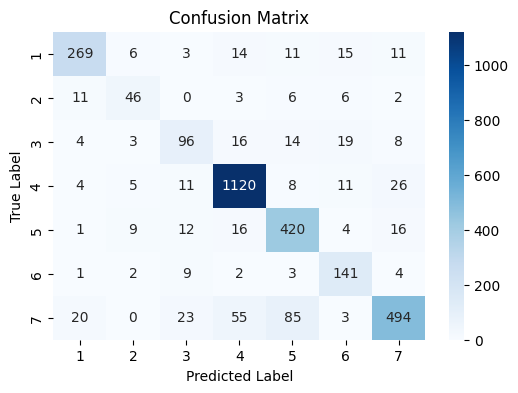

In [13]:
# Generate confusion matrix
cm = confusion_matrix(true_class_labels, predicted_labels)

# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

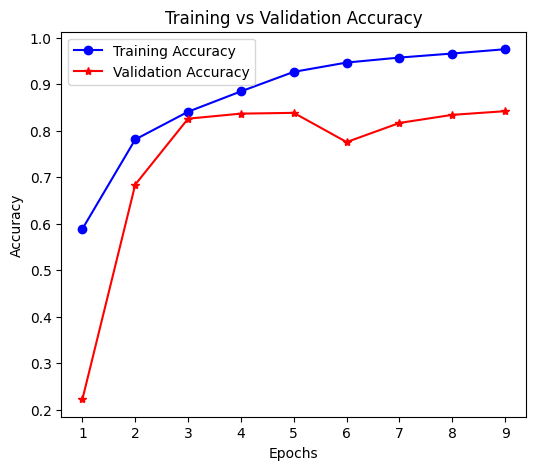

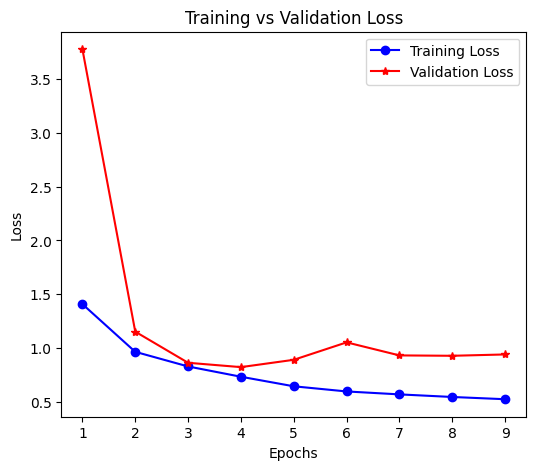

In [14]:
import matplotlib.pyplot as plt

# Define epochs based on history length
epochs = range(1, len(history.history['accuracy']) + 1)

# Plot Training vs Validation Accuracy
plt.figure(figsize=(6, 5))
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Plot Training vs Validation Loss
plt.figure(figsize=(6, 5))
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()